In [1]:
!pip install --upgrade s3fs

In [1]:
import pandas as pd
import numpy as np

# S3 경로
train_path = 's3://smwu-project-datasets/traing-dataset/rtu_data_full.csv'
val_path = 's3://smwu-project-datasets/may-dataset/rtu_ground_truth_may.csv'

In [2]:
raw_df = pd.read_csv(train_path)
val_df = pd.read_csv(val_path)

In [3]:
val_df.head()

,id,hourly_pow,may_bill,may_carbon,agg_pow
0,2025-05-10 00:00:00,39072.258992,7.033007e+06,16566.637813,1.973105e+07
1,2025-05-10 01:00:00,39092.605158,7.036669e+06,16575.264587,1.973105e+07
2,2025-05-10 02:00:00,38988.350044,7.017903e+06,16531.060419,1.973105e+07
3,2025-05-10 03:00:00,38851.406614,6.993253e+06,16472.996405,1.973105e+07
4,2025-05-10 04:00:00,39227.069973,7.060873e+06,16632.277669,1.973105e+07


In [4]:
cols_to_keep = [
    'timestamp',
    'module(equipment)',
    'accumActiveEnergy',  # delta_kWh 계산용
    'activePower'         # 예측 피처
]
train_df = raw_df[cols_to_keep].copy()

In [5]:
# 전처리
def preprocess_data(df):
    # timestamp → datetime 변환
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.sort_values('timestamp', inplace=True)
    df.set_index('timestamp', inplace=True) # 인덱스로 설정

    # 시간 관련 파생 변수 생성
    df['date'] = df.index.date
    df['hour'] = df.index.hour
    df['weekday'] = df.index.weekday
    df['is_weekend'] = df['weekday'].isin([5, 6])  # 주말 여부
    df['is_night'] = df['hour'].between(0, 6)      # 야간 여부

    # 수치형 컬럼에 대한 선형 보간
    numeric_cols = df.select_dtypes(include='number').columns
    df[numeric_cols] = df[numeric_cols].interpolate(method='linear', limit_direction='both')

    # activePower 기반 delta_kWh 계산 (5초 주기 기준)
    df['delta_kWh'] = df['activePower'] * (5 / 3600)

    # 요금 및 탄소 배출량 계산
    df['electricity_cost'] = df['delta_kWh'] * 180
    df['carbon_emission'] = df['delta_kWh'] * 0.424

    return df

In [6]:
train_df = preprocess_data(train_df)

In [7]:
# 1시간 단위 집계
hourly_train = train_df.resample('1H').agg({
    'activePower': 'sum',
    'delta_kWh': 'sum',
}).dropna()

# 추가 피처 생성
hourly_train['hour'] = hourly_train.index.hour
hourly_train['weekday'] = hourly_train.index.weekday
hourly_train['hourly_pow'] = hourly_train['activePower'] * (5 / 3600)
hourly_train['carbon_estimated'] = hourly_train['delta_kWh'] * 0.424
hourly_train['bill_estimated'] = hourly_train['delta_kWh'] * 180

# 확인
print("NaN 비율:", hourly_train['carbon_estimated'].isna().mean() * 100)
print(hourly_train[['carbon_estimated']].head())
print(hourly_train[['carbon_estimated']].tail())
print(hourly_train[['hourly_pow']].head())

NaN 비율: 0.0
                     carbon_estimated
timestamp                            
2024-12-01 08:00:00      16630.139318
2024-12-01 09:00:00      16633.255630
2024-12-01 10:00:00      16508.020458
2024-12-01 11:00:00      16564.361154
2024-12-01 12:00:00      16599.239947
                     carbon_estimated
timestamp                            
2025-04-30 03:00:00      16586.810470
2025-04-30 04:00:00      16638.036589
2025-04-30 05:00:00      16494.283176
2025-04-30 06:00:00      16656.213287
2025-04-30 07:00:00         22.982737
                       hourly_pow
timestamp                        
2024-12-01 08:00:00  39222.026694
2024-12-01 09:00:00  39229.376486
2024-12-01 10:00:00  38934.010514
2024-12-01 11:00:00  39066.889514
2024-12-01 12:00:00  39149.150819


In [8]:
!pip install tensorflow

In [9]:
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
import numpy as np
import random
import tensorflow as tf

np.random.seed(10)
random.seed(10)
tf.random.set_seed(10)

ts = hourly_train['bill_estimated'].dropna().values.reshape(-1, 1)  # (n, 1) 형태로

2025-05-29 19:13:25.132755: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-29 19:13:25.752020: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748546005.961717   22231 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748546006.022773   22231 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748546006.538925   22231 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [10]:
# 정규화 - RobustScaler 사용
scaler = RobustScaler()
ts_scaled = scaler.fit_transform(ts)

In [11]:
# 시퀀스 생성
def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)

SEQ_LEN = 24  # 과거 24시간 사용
X, y = create_sequences(ts_scaled, SEQ_LEN)

In [12]:
# 학습
split_idx = len(X) - len(val_df)
X_train, X_val = X[:split_idx], X[split_idx:]
y_train, y_val = y[:split_idx], y[split_idx:]

In [13]:
from tensorflow.keras.callbacks import EarlyStopping


model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(SEQ_LEN, 1)),
    Dropout(0.1), 
    LSTM(32),
    Dense(16, activation='relu'),  # 중간 표현력 강화
    Dense(1)
])

model.compile(optimizer='adam', loss='mae')  # MAE or Huber

# EarlyStopping 콜백 설정
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# 학습
model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,                 # 충분히 크게 두고
    batch_size=32,
    callbacks=[early_stop],    # EarlyStopping 적용
    verbose=2
)

Epoch 1/100


W0000 00:00:1748546011.690719   22231 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


96/96 - 4s - 43ms/step - loss: 0.7012 - val_loss: 1.2339
Epoch 2/100
96/96 - 1s - 13ms/step - loss: 0.7008 - val_loss: 1.2340
Epoch 3/100
96/96 - 1s - 13ms/step - loss: 0.7005 - val_loss: 1.2336
Epoch 4/100
96/96 - 1s - 13ms/step - loss: 0.7010 - val_loss: 1.2340
Epoch 5/100
96/96 - 1s - 13ms/step - loss: 0.7003 - val_loss: 1.2339
Epoch 6/100
96/96 - 1s - 13ms/step - loss: 0.7003 - val_loss: 1.2341
Epoch 7/100
96/96 - 1s - 13ms/step - loss: 0.7003 - val_loss: 1.2338
Epoch 8/100
96/96 - 1s - 13ms/step - loss: 0.7001 - val_loss: 1.2340
Epoch 9/100
96/96 - 1s - 14ms/step - loss: 0.7001 - val_loss: 1.2339
Epoch 10/100
96/96 - 1s - 14ms/step - loss: 0.7001 - val_loss: 1.2338
Epoch 11/100
96/96 - 1s - 14ms/step - loss: 0.7000 - val_loss: 1.2337
Epoch 12/100
96/96 - 1s - 15ms/step - loss: 0.6998 - val_loss: 1.2336
Epoch 13/100
96/96 - 1s - 14ms/step - loss: 0.7005 - val_loss: 1.2338
Epoch 14/100
96/96 - 1s - 13ms/step - loss: 0.7000 - val_loss: 1.2339
Epoch 15/100
96/96 - 1s - 14ms/step - los

In [14]:
# 예측
y_pred = model.predict(X_val)

# 역정규화
bill_pred_lstm = scaler.inverse_transform(y_pred)
bill_actual = scaler.inverse_transform(y_val)

# 날짜 인덱스 붙이기
lstm_index = pd.date_range(start="2025-05-10 00:00:00", periods=len(bill_pred_lstm), freq='H')
carbon_pred_lstm_series = pd.Series(bill_pred_lstm.flatten(), index=lstm_index)

# 평가
mae = mean_absolute_error(bill_actual, bill_pred_lstm)
mape = mean_absolute_percentage_error(bill_actual, bill_pred_lstm) * 100
r2 = r2_score(bill_actual, bill_pred_lstm)

print(f"LSTM 평가 결과:")
print(f"MAE: {mae:.2f} 원")
print(f"MAPE: {mape:.2f} %")
print(f"R²: {r2:.4f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
LSTM 평가 결과:
MAE: 27884.00 원
MAPE: 142.93 %
R²: -0.0016


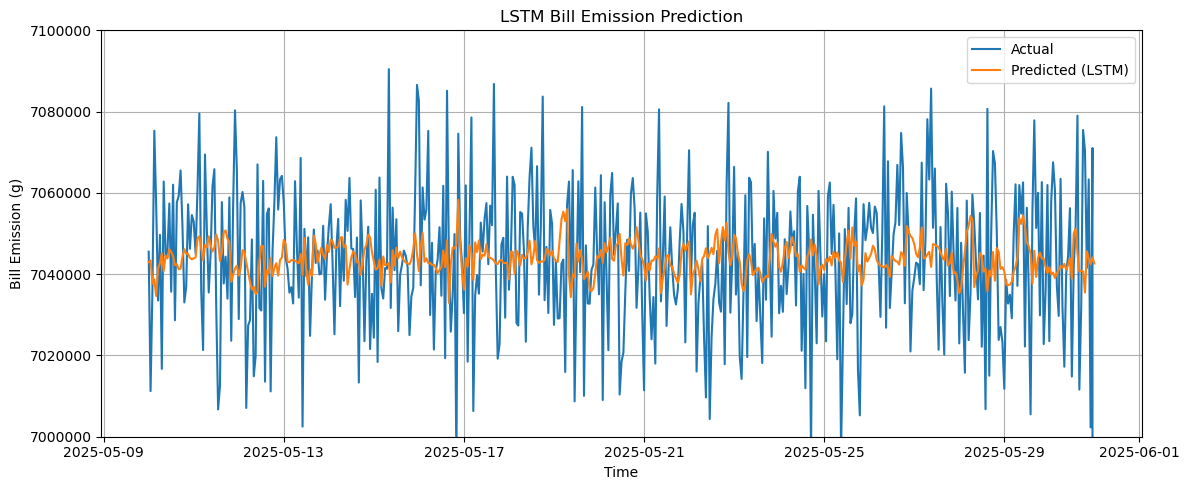

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(lstm_index, bill_actual, label="Actual")
plt.plot(lstm_index, bill_pred_lstm, label="Predicted (LSTM)")
plt.title("LSTM Bill Emission Prediction")
plt.ylabel("Bill Emission (g)")
plt.xlabel("Time")
plt.legend()
plt.grid(True)
plt.ticklabel_format(style='plain', axis='y')  # y축에 지수 표기 제거
plt.ylim([7000000, 7100000])
plt.tight_layout()
plt.show()

In [16]:
print("평균값:", bill_actual.mean())
print("MAE:", mae)
print("상대 오차(%):", mae / bill_actual.mean() * 100)

평균값: 7029985.608009901
MAE: 27884.004841584145
상대 오차(%): 0.39664383963764255


In [17]:
print("실제 요금 총합: ", bill_actual.sum())
print("예측 요금 총합: ", bill_pred_lstm.sum())

# 절대 오차
abs_error = abs(bill_actual.sum() - bill_pred_lstm.sum())

# 상대 오차 (%)
relative_error_percent = abs_error / bill_actual.sum() * 100

print(f"절대 오차: {abs_error:.2f} g")
print(f"상대 오차: {relative_error_percent:.4f} %")

실제 요금 총합:  3550142732.045
예측 요금 총합:  3557140500.0
절대 오차: 6997747.95 g
상대 오차: 0.1971 %


In [18]:
#model.save("bill_model_v1.h5")

In [19]:
# import joblib
# joblib.dump(scaler, 'bill_scaler.pkl')

['bill_scaler.pkl']

In [20]:
# # 안전하게 재설정
# del X_train, y_train, X_val, y_val, scaler, model